In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML

from myst_nb import glue

rc = {
    "figure.dpi": 150,
}
sns.set_theme(style="white", rc=rc)

(sec:compression)=
# 情報圧縮の基礎

現代社会において、画像や動画、音楽などのデジタル・メディアに触れずに生活することは当たり前となっている。しかし、例えば、私たちのスマートフォンに画像や音楽のデータを大量に保存できたり、インターネットから高速にこれらのメディアをダウンロードできるのは**情報圧縮**の恩恵が大きい。

## 情報圧縮と情報量

情報圧縮の仕組みについて理解するには、**情報量**についての理解を深めておく必要がある。情報量とは、情報の量を表すわけだが、同じ128キロバイトのデータが与えられたとして、情報量は同じと言えるのだろうか。

以下の二つの文字列を見てみよう。

**文字列1**

```text
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
```

**文字列2**

```text
NJALKJIOEKQOIEJOAIJEAOIJDAOIJDAO
JOIEAJOIJEAOIJDAOIJHTIUOEIQ73198
JOAI8939068KJZHOIER0AJEOIQHJ04K9
LIJAEOI903908OLANIOEA098UALI3470
7RA98U05ANLEIAJRA04A5HJO945A0944
0958A4HJ0PTFAIUERA0958A4JHOPA8P4
5480PSW4LH5S9485W0HJOARHAOLI84A5
RAJ30985ALTSO9480VJNAS0485WQ0805
```

まず、これらの文字列をテキストファイルに保存して、サイズを確認してみよう。

```{image} ./imgs/file_size.jpg
:width: 50%
```

正しく保存できていれば、ファイルサイズは270バイト前後になるはずである。これは、ファイルの各行が16のASCII文字であり各文字が1バイトで表されていること、各行の終わりに改行の記号として`\r\n`の2バイトが含まれていることを考えれば自然だろう。

では、これら2つのファイルを別々にZIP圧縮してみると、ファイルサイズはどのように変化するだろうか。結果については各自で調べて見てほしいが、文字列1の方が、ファイルサイズが小さくなるはずだ。

文字列1と文字列2を比較すると、文字列1は全ての文字がAの文字列、文字列1は英数字がおよそランダムにならんだ文字列である。上記のように単にASCII文字列を各1バイトのデータとして扱うことは実は効率が悪く、同じ文字が多く出現する場合には、データサイズを**情報量**の観点から削減することができる。

情報量について考える時、複数種類の文字を識別するのに必要なビット数について考えてみたい。もしファイル中に文字が1種類しか現れなければ、そもそも識別が必要がないので、**識別に必要な情報は0ビットである**。

一方で、文字の数が3種類になったときには、単純に考えれば、2ビットのデータが必要だが、この時にデータの表し方を多少工夫することができる。例えば、3種類の文字がA, B, Cであるとき、これらを単純に2ビットのデータで区別しようとするなら、

* A: 00
* B: 01
* C: 10
  
のように表せば良いだろう。しかし、それらの文字の出現率に差があり、Aが50%、Bが25%、Cが25%の確率で出現するとすれば、**Aにより少ないビット**を割り当て、**BとCには2ビット**を割り当てれば、より効率が良い。すなわち、A、B、Cの三文字を、

* A: 0
* B: 10
* C: 11
 
のように表すことにすれば、3つの文字から構成された文字を先頭から読んでいく限りにおいて識別可能であり、Aの出現率がより高いことを加味すると、より少ないビット数でデータが表現できることが分かる。

例えば、`001011101011`のようなビット列であれば、

`0`, `0`, `10`, `11`, `10`, `10`, `11`

のように分解することができて、データが文字列`AABCBBC`に対応することが分かる。

### 情報量の定義

以上の議論から、とあるデータの情報量を考える際 (簡単のために、このデータが文字列のデータだとすると)、情報量と、各文字$i$がファイル内にどのくらいの頻度で現れるかを表す確率$p_i$とは何らかの関係性を持っていることが分かるだろう。

上記の説明では、2つの文字を識別するのには1ビットのデータを割り当てる必要があり、$n$種類のデータを識別しようと思うと、$\log_2 n$ビットが必要になる。しかし、出現確率に偏りがあるのであれば、より多く出現する文字には最小の1ビットを、より少なく出現する文字には、理論的に必要なビット数である$\log_2 n$ビットを割り当てれば、全体のデータ量を減らすことができる。

より抽象的には、出現確率が$p_i$であるような文字$i$に割りあてるべき情報量 (これを**自己情報量**と呼ぶ)を$-\log p_i$で表す。この際、出現頻度が低く、より0に近い$p_i$の方が、より多くの自己情報量が必要になっていることに注意してほしい。

この自己情報量に各文字の出現確率をかければ、その文字がデータ内で占める情報量が計算できる。従って、データ全体の情報量は、

$$
\sum_{i} -p_i \log p_i
$$

という形で表すことができる。この形で表される各文字の自己情報量の重み付き平均を特に**平均情報量**や**エントロピー**と呼ぶ。

### 平均情報量の計算

では、これまでの情報量の定義に基づき、冒頭に示した文字列1と文字列2の情報量を計算してみよう。

まずは、各文字列について、文字列中の各文字の出現回数を、ヒストグラムとして表してみる。ヒストグラムの計算には辞書型の変数を使うと便利だろう。ヒストグラムを計算してMatplotlibを用いてグラフ化したものが以下である。

In [2]:
text1 = """
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
"""

text2 = """
NJALKJIOEKQOIEJOAIJEAOIJDAOIJDAO
JOIEAJOIJEAOIJDAOIJHTIUOEIQ73198
JOAI8939068KJZHOIER0AJEOIQHJ04K9
LIJAEOI903908OLANIOEA098UALI3470
7RA98U05ANLEIAJRA04A5HJO945A0944
0958A4HJ0PTFAIUERA0958A4JHOPA8P4
5480PSW4LH5S9485W0HJOARHAOLI84A5
RAJ30985ALTSO9480VJNAS0485WQ0805
"""

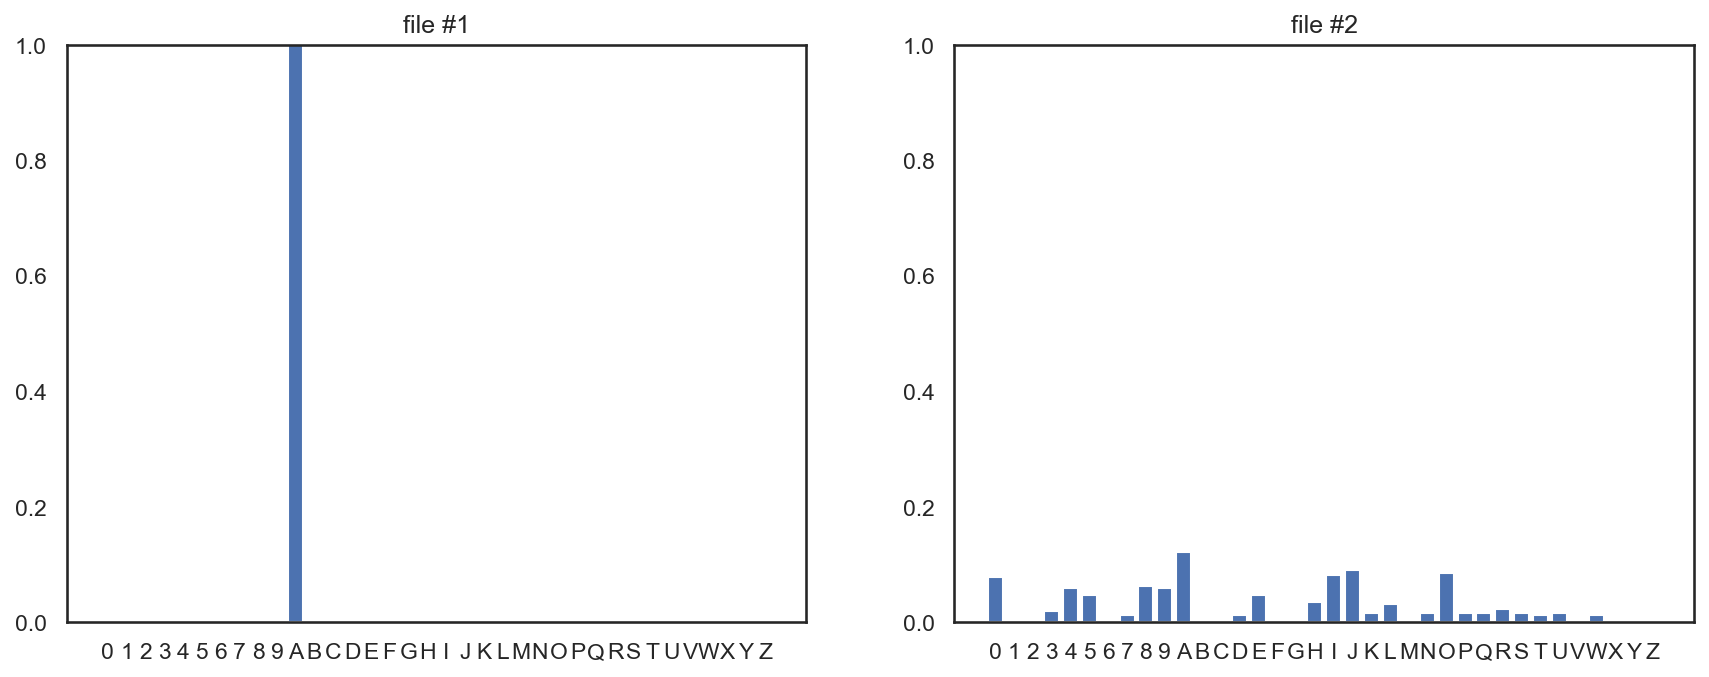

In [3]:
# ヒストグラムの計算
hist1 = {c: 0 for c in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"}
total1 = 0
for c in text1:
    if c in hist1:
        hist1[c] += 1
        total1 += 1
hist1 = {k: v / total1 for k, v in hist1.items()}

hist2 = {c: 0 for c in "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"}
total2 = 0
for c in text2:
    if c in hist2:
        hist2[c] += 1
        total2 += 1
hist2 = {k: v / total2 for k, v in hist2.items()}

# グラフの作成
keys = list(hist1.keys())
values1 = list(hist1.values())
values2 = list(hist2.values())

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(121)
ax.bar(keys, values1)
ax.set_ylim(0, 1.0)
ax.set_title("file #1")
ax = fig.add_subplot(122)
ax.bar(keys, values2)
ax.set_ylim(0, 1.0)
ax.set_title("file #2")
plt.show()

In [4]:
info1 = 0.0
for _, p in hist1.items():
    if p > 0:
        info1 += -p * np.log(p)

info2 = 0.0
for _, p in hist2.items():
    if p > 0:
        info2 += -p * np.log(p)

glue("info1", f"{info1:.3f}")
glue("info2", f"{info2:.3f}")

'0.000'

'2.977'

このヒストグラムの情報を用いて、各文字列の平均情報量を計算すると、文字列1の情報量は{glue:text}`info1`、文字列2の情報量は{glue:text}`info2`となり、情報量の観点からも文字列2の方がより複雑なデータであることが確認できる。

情報圧縮は、与えられたデータに対して、情報量に比例するような形でより少ないデータサイズに圧縮することを目的とすることが多い。情報を圧縮する際には、各データ単位 (これまでの例では文字)をどのような表現 (= 符号)で表すかが重要となる。

以下に、圧縮に用いられる符号化手法をいくつか示すが、ハフマン符号や算術符号は上記の平均情報量に近い形でデータ圧縮することを目指しており、**エントロピー符号**と呼ばれる (平均情報量をエントロピーとも呼ぶため)。

```{admonition} 情報圧縮と情報量
:class: note

- 情報圧縮は、データの情報量に基づいて、より小さいサイズでデータを表す技術
- 情報量(平均情報量)は、各データ単位 (文字など)の出現確率から定まる自己情報量を出現確率で重み付き平均したものである
- 平均情報量に比例するような形でのデータ圧縮を目指すデータの表現法(=符号化)をエントロピー符号化と呼ぶ
```

## 様々な符号化

データ圧縮に用いられる符号化アルゴリズムには、非常に多くの種類があり、前述のエントロピー符号化以外にも、辞書式符号化と呼ばれる方法が広く用いられている。

ここでは代表的な符号化アルゴリズムとして、エントロピー符号化の一種である**ハフマン符号化**と、辞書式符号化の一種である**LZ77符号化**を紹介する。

### ハフマン符号化

ハフマン符号化は、文字の頻度の大小に基づいて、各文字に割り当てるビット数を決定する。ハフマン符号化は、前述の通り、エントロピー符号化の一種であり、**より頻繁に現れる文字には少ないビット**を、**あまり現れない文字には多くのビット**を割り当てることで符号化する。

以下では、文字列`mississippi`を例にとって、ハフマン符号化のアルゴリズムを説明していく。

#### 符号化

まず、各文字の出現頻度を調べる。出現頻度が高い順に文字をソートすると以下の表のようになる。

In [5]:
# 入力文字列
text = "mississippi"

# 出現頻度を調べる
count = {c: 0 for c in text}
for c in text:
    count[c] += 1
count = [(k, v) for k, v in count.items()]
count.sort(key=lambda x: x[1], reverse=True)

In [6]:
df = pd.DataFrame(count, columns=["文字", "出現頻度"])
df.sort_values("出現頻度", inplace=True, ascending=False, ignore_index=True)
display(df)

,文字,出現頻度
0,i,4
1,s,4
2,p,2
3,m,1


ハフマン符号化では、各文字に割り当てられたビットが区別できるよう、出現頻度が多い順に、`0`、`10`、`110`、...のように1が先頭に数個並び、最後に0が現れるようなビット列で書く文字を符号化する。

より具体的には、頻度が$k$番目 ($k = 0, 1, 2, \ldots$)に多い文字は、$k$個の1の後に$0$が付与されたようなビット列で符号化される。

一番出現頻度が低い文字だけは例外で、全てのビットが1のビット列で符号化される。文字列に$n$種類の文字が現れる場合には、出現頻度が最も低い (つまり出現頻度が$k = n - 1$番目)の文字には$n - 1$個の1が並んだようなビット列が付与される。

このルールに従って、各文字にビットを割り当てた結果が以下である。

In [7]:
# ビット列の割り当て
bits = []
for i in range(len(count) - 1):
    bits.append("1" * i + "0")
bits.append("1" * (len(count) - 1))

In [8]:
df2 = pd.concat([df, pd.Series(bits, name="ビット列")], axis=1)
display(df2)

,文字,出現頻度,ビット列
0,i,4,0
1,s,4,10
2,p,2,110
3,m,1,111


In [9]:
# 復号に必要なヘッダ情報
header = {c: b for (c, _), b in zip(count, bits)}

# 符号化後のビット列
body = ""
for c in text:
    if c in header:
        body += header[c]

In [10]:
glue("haffman_out", body)

'111010100101001101100'

これらの結果を用いて、元の文字列`missisippi`を符号化すると、

{glue:text}`haffman_out`

という21ビットのビット列が得られる。

元の文字列を復号するためには、各文字がどのビット列に対応するかを表すヘッダ情報と、符号化後のビット列が必要になる。今回の例では、ヘッダ情報が、8ビットの文字4種類につき、1ビット、2ビット、3ビット、3ビットが割り当てられているので、合計41ビット必要で、上記の符号化後の文字列と合わせると、62ビットのデータになる。

元の文字列は10文字で各文字が8ビットの合計80ビットであったから、ハフマン符号化によりデータ量が削減できていることが分かる。

#### 復号

符号化された文字列を復号するには、各文字のハフマン符号をビット数が未復号の文字の先頭に現れるかどうかを**ビット数が少ない順** (= 出現頻度が高い順)に調べていけば良い。

In [11]:
# 復号処理
dec = ""
pos = 0
while pos < len(body):
    # 未復号文字列の先頭と一致する符号を探す
    for c, b in header.items():
        if body.startswith(b, pos):
            # 一致する符号が見つかったら、その文字を復号文字列に追加
            dec += c
            # 未復号文字をビット数分進める
            pos += len(b)
            break

In [12]:
print(dec)

mississippi


以上、ハフマン符号化は符号化、復号ともに非常にシンプルなアルゴリズムでありながら、高い圧縮性能を持つ圧縮アルゴリズムであることが確認できた。

:::{admonition} ハフマン符号化
:class: note

- ハフマン符号化はエントロピー符号化の一種である
- 出現率の高い文字により少ないビットを割り当てることで高い圧縮率を実現する符号化方式である
- 符号化後のデータは出現する文字と対応するビットを含むヘッダ情報と文字列をそのビットで圧縮したボディ情報から成る
:::

### LZ77符号化

**LZ77符号**はJacob Ziv氏とAbraham Lempel氏によって1977年に発表された符号化手法で、長い歴史を持ちながらもZIPやLZHといった多くの圧縮方式に採用されている符号化手法である。

LZ77符号の優れた点は**スライド辞書**と呼ばれる一時的な辞書を用いることで、**符号化後のデータに辞書データを保持しなくて良い**点にある。この考え方を`missisippi`という文字列を圧縮する場合を例にとって説明する。

#### スライド辞書

スライド辞書は入力の文字列を特定の長さの部分文字列で切り出す窓のことで、LZ77符号化では、この窓を文字列の先頭から走査しながら圧縮処理を行なう。

スライド辞書は最初、空の配列として初期化され、入力文字列の先頭から順に追加されていく。もし辞書内の文字が所定の窓サイズを超えた場合には、キューの要領で、辞書の先頭の文字が取り除かれる。

入力の文字列が`missisippi`で、スライド辞書のサイズが4の時、1文字分ずつ窓がスライドするとすると、次のように辞書内の文字列が変化する。

In [13]:
text = "mississippi"
size = 4

slide = []
history = ["`[]`"]
for c in text:
    slide.append(c)
    while len(slide) > size:
        slide = slide[1:]
    history.append("`" + str(slide) + "`")

display(Markdown(" → ".join(history)))

`[]` → `['m']` → `['m', 'i']` → `['m', 'i', 's']` → `['m', 'i', 's', 's']` → `['i', 's', 's', 'i']` → `['s', 's', 'i', 's']` → `['s', 'i', 's', 's']` → `['i', 's', 's', 'i']` → `['s', 's', 'i', 'p']` → `['s', 'i', 'p', 'p']` → `['i', 'p', 'p', 'i']`

LZ77符号化においては、このスライド辞書の情報を元にして、未圧縮の文字列を符号化する。

#### 符号化

LZ77符号を用いた符号化では、未圧縮の文字の先頭に現れる文字列が、スライド辞書内の文字列と一致するかどうかを調べる。

例えば、入力文字列`missisippi`の4文字目まで圧縮が済んでいる場合を考えてみよう。この時、残っている文字列は`issippi`であり、スライド窓には`miss`の4文字が格納されている。

この場合、`miss`内で、文字列`issippi`と一致する最大文字列は`iss`であり、スライド窓内の1文字目から3文字分一致する。このような一致情報を`(1, 3)`のように、**一致開始位置**と**一致する長さ**の数字の組で表す。

LZ77符号化では、さらに、未圧縮文字とスライド辞書をマッチングしたときに、最初に**マッチしなかった**文字を、上記の一致開始位置、一致する長さ、とともに出力する。従って、`missisippi`の5文字目の`i`は`(1, 3, "i")`のような情報として符号化される。

また、複数の文字がマッチした場合には、スライド辞書がマッチした文字数分スライドすることに注意してほしい。

この処理を、文字列`missisippi`の先頭から順に実施すると、各文字は以下のように符号化される。

In [14]:
text = "mississippi"

slide = ""
body = []
history = []
pos = 0

while pos < len(text):
    # スライド窓の文字列を検索
    start = 0
    n_max = 0
    for i in range(len(slide)):
        n = 0
        for j in range(len(slide)):
            if i + j < len(slide) and pos + j < len(text):
                if slide[i + j] == text[pos + j]:
                    n += 1
                    continue
            break

        if n_max < n:
            start = i
            n_max = n

    # 文字列が見つからなければ、その文字を出力
    body.append((start, n_max, text[pos]))
    history.append((text[pos:], "".join(slide), body[-1]))

    # 探索位置の更新
    pos += max(1, n_max)
    slide = text[max(0, pos - size) : pos]

In [15]:
df = pd.DataFrame(history, columns=["未圧縮文字列", "スライド辞書", "出力"])
display(df)

,未圧縮文字列,スライド辞書,出力
0,mississippi,,"(0, 0, m)"
1,ississippi,m,"(0, 0, i)"
2,ssissippi,mi,"(0, 0, s)"
3,sissippi,mis,"(2, 1, s)"
4,issippi,miss,"(1, 3, i)"
5,ippi,siss,"(1, 1, i)"
6,ppi,issi,"(0, 0, p)"
7,pi,ssip,"(3, 1, p)"
8,i,sipp,"(1, 1, i)"


最後に出力のデータをビットに変換する。この例では、スライド辞書のサイズが4であるので、開始位置と一致文字長が2ビット、次の不一致文字が8ビットで表せる。これらを踏まえると最終的に得られるビット列は以下のように計算できる。

In [16]:
bits = ""
for s, n, c in body:
    bits += f"{start:02b}{n:02b}{ord(c):08b}"

print(f"符号化後のビット長: {len(bits):d}")
print(f"ビット列:", bits)

符号化後のビット長: 108
ビット列: 010001101101010001101001010001110011010101110011011101101001010101101001010001110000010101110000010101101001


今回の例では、元の文字列のサイズが80ビット、圧縮後のデータサイズが108ビットとなり、符号化によりデータサイズは減らすことはできなかった。しかし、同様の処理をより長い文章に対して、大きなサイズのスライド辞書を用いて実行できれば、より良い圧縮率を得ることができるだろう。

#### 復号

この圧縮の結果として得られるデータは、表の**出力**の列を配列にしたデータである。この際、**出力の情報から、スライド辞書に含まれる情報が完全に復元可能**である、というのがLZ77符号化の優れた点である。

In [17]:
dec = ""
slide = ""
size = 4
pos = 0

while pos < len(bits):
    # スライド辞書の開始位置、一致文字長、不一致文字を取り出す
    start = int(bits[pos : pos + 2], 2)
    pos += 2
    n = int(bits[pos : pos + 2], 2)
    pos += 2
    c = chr(int(bits[pos : pos + 8], 2))
    pos += 8

    if n == 0:
        # 一致文字長が0の時は、不一致文字を追加
        dec += c
    else:
        # 一致文字長が0より大きい時は、スライド辞書から文字列を取り出す
        dec += slide[start : start + n]

    # スライド辞書の更新
    slide = dec[-size:]

In [18]:
print(dec)

misiisiipii


このように、LZ77は、スライド辞書により、圧縮データに明示的に辞書を含めなくて良く、その分、効率的なデータ圧縮が期待できる。

また、LZ77にはLZ78やLZSSといった亜種が複数存在し、ZIP圧縮にも用いられるDeflateというアルゴリズムはLZSSとハフマン符号化を組み合わせた圧縮アルゴリズムである。

:::{admonition} LZ77符号化
:class: note

- LZ77はスライド辞書と呼ばれる一時辞書によって、辞書を圧縮データに含めなくても済むように工夫している
- 符号化処理では、未圧縮文字列の先頭に現れる文字パターンがスライド辞書内に存在するか否かを調べる
- LZ78やLZSS等の亜種が存在し、ZIPファイル形式の他、画像の圧縮 (後述するPNG形式)にも用いられている
:::


## 画像データの圧縮

それでは、ここまでに学んだ内容を応用して、画像データの圧縮について考えてみる。

画像データにはJPEG (Joint Photographic Experts Group)方式やPNG (Portable Network Graphics)方式など、非常に多くの圧縮方式がある。これらの方式が大きく**可逆圧縮**と**不可逆圧縮**に分けることができる。

可逆圧縮は、圧縮前のデータを完全に復元できる圧縮形式である。一方、不可逆圧縮は、圧縮前のデータを近似的には再現できるものの、完全には再現できない圧縮方式を指す。その代わり、不可逆圧縮は可逆圧縮に比べて大きくデータサイズを減らすことができるという利点もある。

前述の方式の中ではJPEG方式は不可逆圧縮、PNG方式は可逆圧縮である。以下では写真を始めとする画像データの圧縮に広く用いられるJPEG方式の圧縮アルゴリズムについて紹介する。

なお、PNG方式の画像圧縮には前述のLZ77の亜種であるLZSSとハフマン符号化を組み合わせたDeflateというアルゴリズムが使われている。

### 入力データ

今回はJPEG方式の概要だけをつかむため、以下の512×512画素のグレースケール画像の圧縮に取り組む。

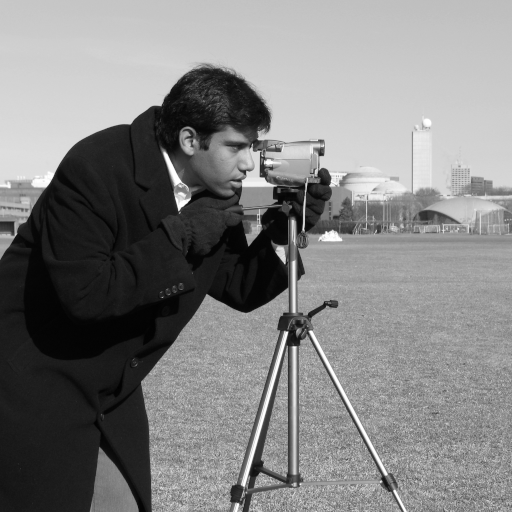

In [19]:
import skimage
from PIL import Image

image = skimage.data.camera()
image = Image.fromarray(image)
glue("image", image)

image = np.array(image, dtype="uint8")

各自、上記の画像をダウンロードし、`camera.png`のような名前をつけて保存しておこう。なお、この画像はPNG方式という方式で圧縮されているが、前述の通り、JPEG方式により圧縮率の向上が見込まれる。

画像の読み込みには、軽量な画像処理のためのライブラリである**Pillow**を用い、後の処理がやりやすいようにNumPyの配列に変換しておく。

```python
import numpy as np
from PIL import Image

image = Image.open("camera.png")
image = np.array(image)
```

### 離散コサイン変換 (DCT)

JPEG方式の画像圧縮の重要なアイディアに**離散コサイン変換** (DCT, discrete cosine transform)がある。以下では、離散コサイン変換が、余弦関数の足し合わせにより離散信号を表すものだという理解にとどめて、JPEG方式でのDCTの利用法について説明する。

DCTについて、より詳しく知りたい読者は、本項末の[補足: 離散コサイン変換](ssec:dct)を参照のこと。

JPEG方式の画像圧縮では、画像を8x8の画像断片に分割して、その断片ごとに二次元のコサイン変換を施す。視覚的には、以下の64種類の二次元信号の足し合わせにより、断片内の画像信号を表す。

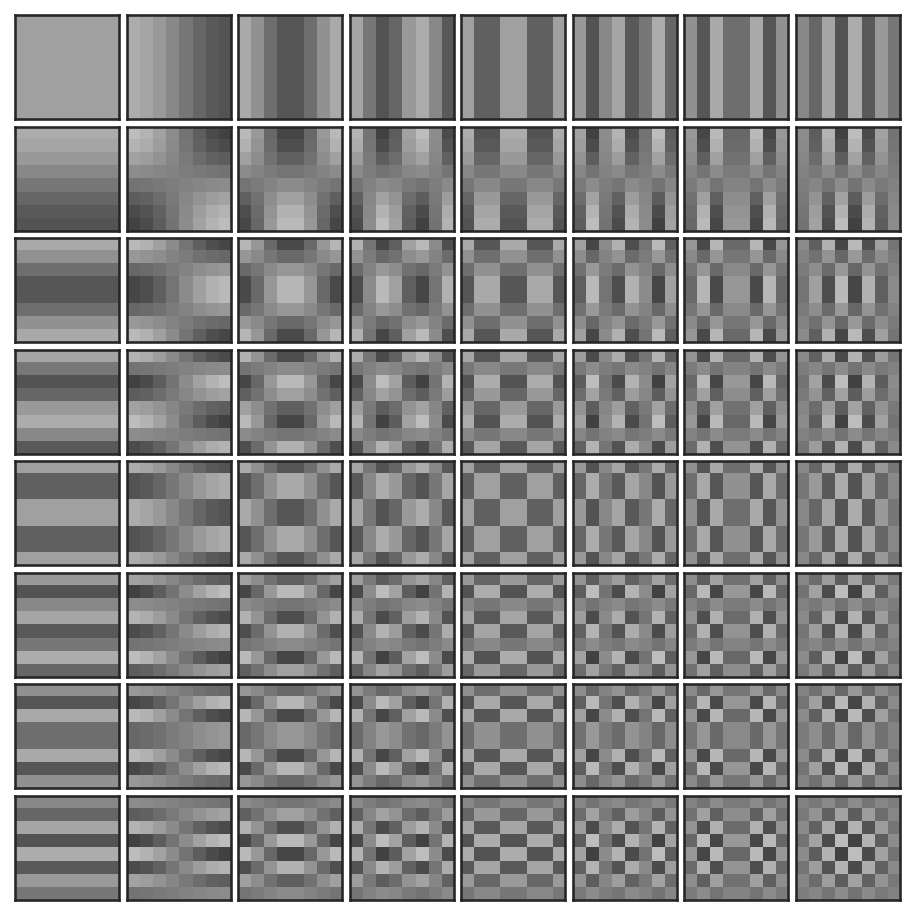

In [20]:
import scipy as sp

res = []
for i in range(8):
    for j in range(8):
        b = np.zeros((8, 8))
        b[i, j] = 1.0
        b = sp.fftpack.idct(sp.fftpack.idct(b, axis=0, norm="ortho"), axis=1, norm="ortho")
        res.append(b)

fig, axes = plt.subplots(8, 8, figsize=(6, 6))
for ax, b in zip(axes.flat, res):
    ax.imshow(b, cmap="gray", vmin=-0.5, vmax=0.5)
    ax.set(xticks=[], yticks=[])

fig.tight_layout(pad=0.3)
plt.show()

この二次元コサイン変換を各8x8の画像断片に適用するために、画像を断片に分割する。NumPyの配列には、多次元配列の形を変形する[reshape](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html)と、次元の順序を入れ替える[transpose](https://numpy.org/doc/stable/reference/generated/numpy.transpose.html)が用意されているのでこれらを用いる。

In [21]:
# 画像サイズの取得
H, W = image.shape
patches = image.reshape((H // 8, 8, W // 8, 8))
patches = patches.transpose(0, 2, 1, 3).reshape(-1, 8, 8)

# 変換前後のサイズを確認
print(f"{(H, W)} → {patches.shape}")

(512, 512) → (4096, 8, 8)


画像を断片に分割できたら、SciPyに用意されている`dct`関数を用いて、それぞれの断片をコサイン関数の係数に変換する。この際、8x8の部分をDCTするために`axes=(1, 2)`を、離散コサイン変換と、その逆変換について、同様の正規化を行なうために`norm="ortho"`を指定すること (詳細は[補足: 離散コサイン変換](ssec:dct)を参照)。

In [22]:
import scipy as sp

dct = sp.fftpack.dctn(patches, axes=(1, 2), norm="ortho")

以上で、画像断片のコサイン変換が完了した。各8x8のDCT係数には実数値が格納されているので、以下では、これらの係数の大きさがどうなっているかを元の画像上に再配置して可視化してみる。

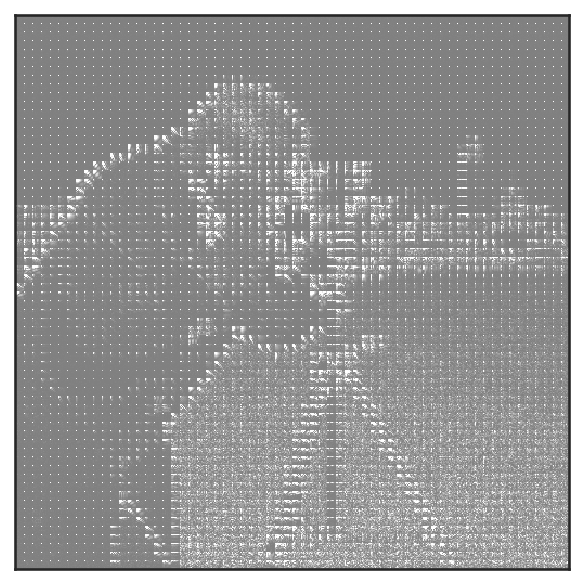

In [23]:
import matplotlib.pyplot as plt

# DCT係数を元の画像上に配置
coeff = dct.reshape(H // 8, W // 8, 8, 8).transpose(0, 2, 1, 3).reshape(H, W)

# 係数の表示
fig, ax = plt.subplots()
ax.imshow(np.abs(coeff), cmap="gray", interpolation="none", vmin=-50, vmax=50)
ax.set(xticks=[], yticks=[])
plt.show()

このままだと、係数の配置がやや分かりづらいので、左上の5x5ブロックだけを表示してみる。

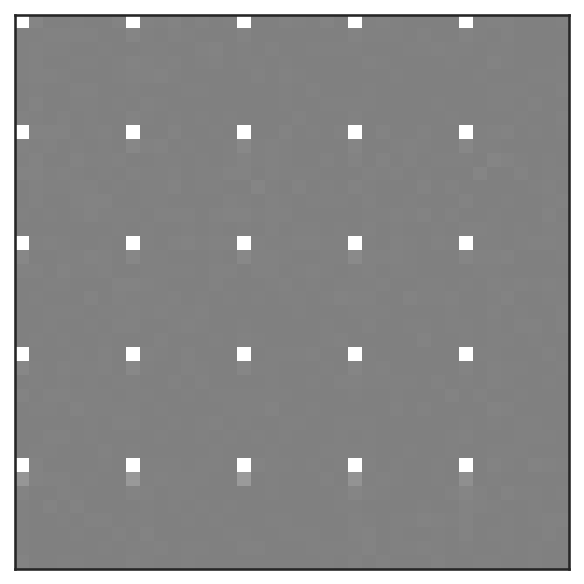

In [24]:
# 係数の表示
fig, ax = plt.subplots()
ax.imshow(np.abs(coeff[:40, :40]), cmap="gray", interpolation="none", vmin=-50, vmax=50)
ax.set(xticks=[], yticks=[])
plt.show()

この可視化結果を確認してみると、各8x8のDCT係数について、最も左上の$(0, 0)$に現れる係数だけが大きな値を取っており、それ以外の係数はほとんど0 (=灰色)であることが確認できる。

### DCT係数の量子化

各8x8のブロックに含まれるDCT係数はその位置によって異なる意味合いを持つ。

最も左上に現れる係数は画像断片内の画素値の平均に対応する成分で、画像を表す上でとても重要な値である。その一方、人間は視覚的に高周波数の信号を知覚しづらいことが知られており、8x8のブロックの右下の方に現れる係数は視覚的に見てそれほど重要ではない。

そこで、各8x8ブロックに現れる実数のDCTブロックを、異なる幅で量子化する。この際、左上に近い位置に現れる係数には小さな量子化定数を、右下に近い位置に現れる係数には大きな量子化定数を割り当てる。

In [25]:
# 量子化テーブル
table = np.array(
    [
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99],
    ]
)

In [26]:
# 量子化されたDCT係数
qdct = (dct / table[None, :, :]).astype("int32")

### DCT係数の並べ替え

DCT係数の量子化と同じ理屈で、8x8のDCT係数は左上に近い方が重要で、右下に行けば行くほど重要度がが下がる。その分、量子化の幅も大きくなるので、右下に行けば行くほど0に近い係数が多くなることが予想される。

そこで、8x8のDCT係数を**ジグザグ・スキャン**と呼ばれる順序で並べ替える。名前の通り、左上の角にある係数から右下の角にある係数までをジグザグの経路で並べ替えるもので、以下のテーブルに示す順序で係数が並べ替えられる。

In [27]:
# ジグザグ・スキャンのテーブル
zigzag = np.array(
    [
        [0, 1, 5, 6, 14, 15, 27, 28],
        [2, 4, 7, 13, 16, 26, 29, 42],
        [3, 8, 12, 17, 25, 30, 41, 43],
        [9, 11, 18, 24, 31, 40, 44, 53],
        [10, 19, 23, 32, 39, 45, 52, 54],
        [20, 22, 33, 38, 46, 51, 55, 60],
        [21, 34, 37, 47, 50, 56, 59, 61],
        [35, 36, 48, 49, 57, 58, 62, 63],
    ]
)

In [28]:
# ジグザグ・スキャンによる係数の並び替え
qdct = qdct.reshape((len(qdct), -1))
print(qdct.shape)
ordered = np.zeros_like(qdct)
for i in range(64):
    ordered[:, zigzag.flatten()[i]] = qdct[:, i]

(4096, 64)


並べ替えが済んだら、左上の係数に対応する直流成分 (DC, direct current)と、それ以外の係数に対応する交流成分 (AC, alternate current)に係数を分割しておく。

In [29]:
dc = ordered[:, 0].reshape((-1))
ac = ordered[:, 1:].reshape((-1))

ここで注目すべきは、直流成分の多くが非ゼロの値を取るのに対して、交流成分はほとんどの値が0である、という点である。この点に着目して、直流成分と交流成分の情報をさらに圧縮していく。

### 直流成分の圧縮

JPEG方式において、直流成分と交流成分を圧縮する際には、どちらもハフマン符号化が用いられる。

このハフマン符号化では、16ビット符号付き整数である-32767から32767の整数を**グループ番号**と**付加ビット**の2つの整数の組で表す。

各数字を符号化するのに用いるグループ番号と付加ビット数 (付加ビットそれ自体ではないので注意)は以下のようになっている。

In [30]:
haffman = []
for i in range(16):
    if i == 0:
        haffman.append((0, 0, 0))
    else:
        a = 0x01 << (i - 1)
        b = 0x01 << i
        if a == b - 1:
            r = f"{-b+1}, {b-1}"
        elif a + 1 == b - 1:
            r = f"{-b+1}, {-a}, {a}, {b-1}"
        else:
            r = f"{-b+1}, ..., {-a}, {a}, ..., {b-1}"
        haffman.append((r, i, i))

df = pd.DataFrame(haffman, columns=["範囲", "グループ番号", "付加ビット数"])
display(df)

,範囲,グループ番号,付加ビット数
0,0,0,0
1,"-1, 1",1,1
2,"-3, -2, 2, 3",2,2
3,"-7, ..., -4, 4, ..., 7",3,3
4,"-15, ..., -8, 8, ..., 15",4,4
5,"-31, ..., -16, 16, ..., 31",5,5
6,"-63, ..., -32, 32, ..., 63",6,6
7,"-127, ..., -64, 64, ..., 127",7,7
8,"-255, ..., -128, 128, ..., 255",8,8
9,"-511, ..., -256, 256, ..., 511",9,9


この時、各グループに属する整数の数が付加ビットで表せる数字の数と同じになっている点に注目してほしい。

例えば、グループ番号が4のグループは範囲が-15, ..., -8, 8, ..., 15となっており、合計16種類の数が含まれる。16種類の整数を表すには、4ビットあれば良く、この範囲内の数字が付加ビットによりエンコードされる。

すなわち、12という数字を符号化する場合、グループ番号は4 (2進数で`0100`)であり、グループ内では11番目の数字なので2進数で`1011`と表せる。従って、12は`01001011`と符号化される。

上記のハフマンテーブルでは、0に近い値の方がより少ないビットで符号化されるので、符号化されす整数列も0を多く含んでいる方が良い。直流成分は、隣り合うブロックの平均輝度が連続して並んでいるので、隣同士の成分の値の差が0に近い値であると期待できる。そこで、符号化前に、直流成分を先頭の係数と、隣り合う係数の差の情報に変換する。

In [31]:
dc_0 = dc[0]  # 最初の係数
dc_diff = dc[1:] - dc[:-1]  # 係数の差分

係数の差分が得られたら、そのそれぞれをハフマンテーブルに基づき、グループ番号と付加ビットで符号化する。

In [32]:
dc_bits = ""
for n in dc_diff:
    # グループ番号の計算
    group_id = 0
    m = abs(n)
    while m > 0:
        group_id += 1
        m >>= 1

    # グループ内で何番目か？
    if group_id > 0:
        a = 0x01 << (group_id - 1)
        b = 0x01 << group_id
    else:
        a = b = 0

    if n < 0:
        order = n + b - 1
    else:
        order = n

    # 付加ビットの計算
    if n == 0:
        code = ""
    else:
        code = format(order, f"0{group_id}b")

    # 符号化結果
    group_bit = format(group_id, "04b")

    # ビット列の結合
    dc_bits += group_bit + code

### 交流成分の圧縮

交流成分は直流成分と異なり、既に多くの値が0に近い値を取っていると考えられる。

この際、単に0に近いだけでなく、実際に0であるというのが重要で、交流成分の中身は0が連続する領域が非常に多く存在する。

そこで、0が連続する領域を**ランレングス符号化**により符号化する。ランレングス符号化は連続で現れる同一の記号を **(記号、連続する長さ)** という形式で表す符号化手法である。

JPEG方式では、0でない交流成分を **(その前に続く0の数、非ゼロ交流成分のハフマン符号)** という形で符号化する。

例えば、`1, 0, 0, 0, -2, 0, 0, 0, 0, 5` のような整数列が与えられた時、まず0の成分がランレングス符号化により圧縮され、`(0, 1), (3, -2), (4, 5)`のような形で表される。

あとは、0でない整数である`1`, `-2`, `5`のそれぞれが前述のハフマンテーブルに従い、グループ番号と付加ビットにより符号化される。


なお、実際のJPEG方式では、0が15個以上連続して現れる場合に`ZRL = 0xF`という特殊ビットを用いて表し、15の剰余の部分だけを上記の方法で符号化する。

例えば、0が32個続いた後に、`5`が現れる場合、`ZRL`, `ZRL`, `(2, 5のハフマン符号)`と言う形で表す。

In [33]:
ac_data = []
n_zero = 0
for n in ac:
    if n == 0:
        n_zero += 1
    else:
        ac_data.append((n_zero, n))
        pre_non_zero = n
        n_zero = 0

# 最後は0の数を1つ減らして0を追加
ac_data.append((n_zero - 1, 0))

In [34]:
ac_bits = ""
for n_zero, n in ac_data:
    while n_zero >= 15:
        ac_bits += "1111"
        n_zero -= 15

    nz_bit = format(n_zero, "04b")

    # グループ番号の計算
    group_id = 0
    m = abs(n)
    while m > 0:
        group_id += 1
        m >>= 1

    # グループ内で何番目か？
    if group_id == 0:
        a = b = 0
    else:
        a = 0x01 << (group_id - 1)
        b = 0x01 << group_id

    if n < 0:
        order = n + b - 1
    else:
        order = n

    # 付加ビットの計算
    if n == 0:
        code = ""
    else:
        code = format(order, f"0{group_id}b")

    # 符号化結果
    group_bit = format(group_id, "04b")

    # ビット列の結合
    ac_bits += nz_bit + group_bit + code

このようにして得られた直流成分と交流成分のビットを合わせたものがJPEG方式の符号化結果となる。ビット数は22万ビット = 30KBほどになる。

今回用いた画像はグレースケール画像であり、通常1画素が1バイトで表されるので、非圧縮の状態では512x512 = 260KBほどのデータがある。この点を考慮すると、3KBというデータがいかに少ないデータかが分かるだろう。

### 復号処理

では、ここまでで得られた直流成分・交流成分のデータを復号し、元の画像が再現できるかを確かめてみよう。

In [35]:
# 直流成分の復元
pos = 0
dc_dec = []
while pos < len(dc_bits):
    # グループ番号を取得
    group_id = int(dc_bits[pos : pos + 4], 2)
    pos += 4

    # group_id分の付加ビットを取得
    if group_id > 0:
        code = int(dc_bits[pos : pos + group_id], 2)
        pos += group_id
    else:
        code = 0

    # 元の整数を復元
    if group_id == 0:
        a = b = 0
        dc_dec.append(0)
    else:
        a = 0x01 << (group_id - 1)
        b = 0x01 << group_id
        if code < a:
            dc_dec.append(code - b + 1)
        else:
            dc_dec.append(code)

# dc0の成分を反映して直流成分を復元
dc_dec = dc_0 + np.cumsum([0] + dc_dec)

# 元のデータと同じかをチェック
assert np.all(dc_dec == dc)

In [36]:
# 交流成分を復元
pos = 0
ac_dec = []
while pos < len(ac_bits):
    # 最初の4ビットを読む
    n_zero = int(ac_bits[pos : pos + 4], 2)
    pos += 4

    if n_zero == 0xF:
        # 0xfの場合は、15個の0を復元
        ac_dec.extend([0] * 15)
        continue

    # 0xfでない場合は、その数分0を復元
    ac_dec.extend([0] * n_zero)

    # 以下、0に続く非ゼロ成分を復元
    # グループ番号を取得
    group_id = int(ac_bits[pos : pos + 4], 2)
    pos += 4

    # group_id分の付加ビットを取得
    if group_id == 0:
        code = 0
    else:
        code = int(ac_bits[pos : pos + group_id], 2)
        pos += group_id

    # 元の整数を復元
    if group_id == 0:
        a = b = 0
    else:
        a = 0x01 << (group_id - 1)
        b = 0x01 << group_id

    if code < a:
        ac_dec.append(code - b + 1)
    else:
        ac_dec.append(code)

# 扱いやすくするためにNumPy配列に変換
ac_dec = np.array(ac_dec)

# 元のデータと同じかをチェック
assert np.all(ac_dec == ac)

ここまでで直流成分と交流成分を復元できたので、ジグザグ・スキャンと量子化の処理を元に戻す

In [37]:
# 直流成分と交流成分を統合
dec = np.zeros(((H // 8) * (W // 8), 8 * 8), dtype="int32")
dec[:, 0] = dc_dec
dec[:, 1:] = ac_dec.reshape(-1, 63)

# ジグザグ・スキャンの逆並び替え
qdct_dec = np.zeros_like(dec)
for i in range(64):
    qdct_dec[:, i] = dec[:, zigzag.flatten()[i]]

# 量子化をキャンセル
dct_dec = qdct_dec.reshape((len(qdct_dec), 8, 8)) * table[None, :, :]

以上で、DCT係数が復元できたので、最後に逆離散コサイン変換を行い、画像を復元する。

In [38]:
# 逆離散コサイン変換
image_dec = sp.fftpack.idctn(dct_dec, axes=(1, 2), norm="ortho").reshape(H, W)

# 画像サイズを元に戻す
image_dec = image_dec.reshape((H // 8, W // 8, 8, 8)).transpose(0, 2, 1, 3).reshape(H, W)

# 輝度の範囲を0-255に制限
image_dec = np.clip(image_dec, 0, 255).astype("uint8")

復元した画像を実際に表示してみると、以下の通り、元画像に限りなく近い画像が復元できていることが確認できる。

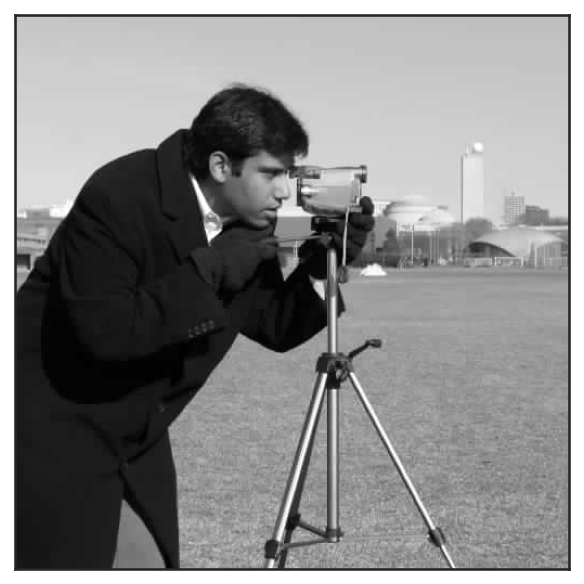

In [39]:
fig, ax = plt.subplots()
ax.imshow(image_dec, cmap="gray")
ax.set(xticks=[], yticks=[])
plt.show()

なお、ここまでの処理はあくまでJPEG方式を説明するための処理について述べただけであり、実際のJPEG方式の圧縮にはもう少し細かなルールが設定されている。これらについて詳しく知りたい読者は参考文献として{cite}`shotatsu2010compression`などを参考にすると良い。

:::{admonition} 画像データの圧縮
:class: note

- 画像等のメディアの圧縮には可逆圧縮と非可逆圧縮がある
- 非可逆圧縮は高い圧縮率を実現できるが、元データを近似的にしか再現できない
- JPEG方式の画像圧縮には、DCT、ハフマン符号化、ランレングス符号化などの技術が用いられる
:::

## 練習問題

In [40]:
text = """
Born in 1879 in Germany, I initially struggled with the traditional educational system but went on to develop revolutionary theories that transformed our understanding of how the universe operates. My most notable work includes the theory of relativity, which comprises both the general and special theories. I was awarded the Nobel Prize in Physics in 1921 not for relativity, but for my explanation of the photoelectric effect, a cornerstone in quantum physics. Who am I?
""".strip()

In [41]:
# LZ77符号化
slide = ""
size = 16
body = []
pos = 0

while pos < len(text):
    # スライド窓の文字列を検索
    start = 0
    n_max = 0
    for i in range(len(slide)):
        n = 0
        for j in range(len(slide)):
            if i + j < len(slide) and pos + j < len(text):
                if slide[i + j] == text[pos + j]:
                    n += 1
                    continue
            break

        if n_max < n:
            start = i
            n_max = n

    # 文字列が見つからなければ、その文字を出力
    body.append((start, n_max, text[pos]))

    # 探索位置の更新
    pos += max(1, n_max)
    slide = text[max(0, pos - size) : pos]

In [42]:
bits = ""
for s, n, c in body:
    bits += format(s, "04b") + format(n, "04b") + format(ord(c), "08b")

print(len(text) * 8, len(bits))

3784 6928


In [43]:
hex_data = ""
for i in range(0, len(bits), 4):
    n = int(bits[i : i + 4], 2)
    hex_data += format(n, "1x")

lines = []
for i in range(0, len(hex_data), 64):
    lines.append(hex_data[i : i + 64])

```{card}
**問1**
^^^
以下の16進数で表された文字列は、とある文章を大きさ16のスライド辞書を用いてLZ77符号化したものである。元の文章を復号して、得られる問に答えよ。

なお、以下の文字列は、見やすくするために64文字ごとに改行が入れてあるので、改行を削除した後に復号処理を行うこと。
```

In [44]:
print("\n".join(lines))

0042006f0072006e00200069326e00310038003700394420004700650172006d
0061116e0079002c41200049232001690074c1694161006cf16c317941200073
8174007200750067f167616c00650064612000770069517400681120d2746165
c22000720061216442692169006f006e9161006c012021656164007500632161
477400730079e17361740165006d9120006200750174512000778165006eb274
006fc16e41200174c16f11200064516500763165006c516f0070212000728265
316f816c007500740069516f006e0061517200792120817400681165216f9172
4169c165007373201161417422205172b161006e51730066006fa172006d0065
00644120a16f007531720120d175216e816461653172007300740061926e0069
616e00672120006f0066d1200068c16f007791201174b168006551200075116e
00690076a165007200737265016f007092650061007451656173002e6120004d
00793120006d216f817351748120006eb16f117400610062006c006501200077
316f0072006b31200069216e0063516c0075006431650073212000740068b165
c420006f007200795120c16f00662120a1723165006c0061217400690076e169
c1742179002c11200077006871690063d168a120d163006f006d007000720169
00730065e17301200062616f0

In [45]:
dec = ""
slide = ""
size = 16
pos = 0

while pos < len(hex_data):
    # スライド辞書の開始位置、一致文字長、不一致文字を取り出す
    start = int(hex_data[pos : pos + 1], 16)
    pos += 1
    n = int(hex_data[pos : pos + 1], 16)
    pos += 1
    c = chr(int(hex_data[pos : pos + 2], 16))
    pos += 2

    if n == 0:
        # 一致文字長が0の時は、不一致文字を追加
        dec += c
    else:
        # 一致文字長が0より大きい時は、スライド辞書から文字列を取り出す
        dec += slide[start : start + n]

    # スライド辞書の更新
    slide = dec[-size:]

print(dec)

Born in 1879 in Germany, I initially struggled with the traditional educational system but went on to develop revolutionary theories that transformed our understanding of how the universe operates. My most notable work includes the theory of relativity, which comprises both the general and special theories. I was awarded the Nobel Prize in Physics in 1921 not for relativity, but for my explanation of the photoelectric effect, a cornerstone in quantum physics. Who am I?


## 参考文献

```{bibliography}
:labelprefix: 5-
:filter: docname in docnames
```

(ssec:dct)=
## 補足: 離散コサイン変換

類似の変換である**フーリエ級数展開**では、実数値の信号に対しても複素数の値が現れることがあるが、扱う信号を偶関数に限定すると、実係数のコサイン関数の足し合わせとして、元の実信号を表せる。この考え方を利用したものがコサイン変換である。

入力の信号$I(t)$が周期$T$を持ち、偶関数で表せる連続信号である場合、以下のような無限級数により、$I(t)$が表せる。

$$
I(t) = \frac{a_0}{2} + \sum_{n=1}^{\infty} a_n \cos\left( \frac{2\pi n t}{T} \right)
$$

この時、各$a_n$は以下のように表せる。

$$
a_n = \frac{2}{T} \int_0^T I(t) \cos \left( \frac{2\pi n t}{T} \right) \mathrm{d}t
$$

**離散**コサイン変換の場合には、離散的な信号を同様の形式で表し、フーリエ級数展開に現れる係数$a_n$が離散コサイン変換の結果として与えられる。

詳細は割愛するが、入力の信号が離散的な信号である場合、その信号が持つ周波数には上限がある。従って、フーリエ級数に表れる項も有限で抑えらる。特に離散信号が$N$点の観測値として与えられるときには、高々$N$個のコサイン関数の足し合わせにより、元の離散信号が表せる。

$$
x_k =　\frac{X_0}{2} + \sum_{n=1}^{N - 1} X_n \cos\left( \frac{\pi}{N} n \left( k + \frac{1}{2} \right) \right)
$$ (eq:idct)

この級数にコサイン関数の係数として表れる$X_0$, $X_1$, ..., $X_{n - 1}$が離散コサイン変換結果となる。各係数は、連続値の場合の積分を和として表した次式により計算できる。

$$
X_k = \frac{2}{N} \sum_{n=0}^N x_n \cos \left( \frac{\pi}{N} \left( n + \frac{1}{2} \right)k \right)
$$ (eq:dct)

ただし、コサイン変換の{eq}`eq:dct`に現れる係数の$\frac{2}{N}$は、計算上は{eq}`eq:idct`と{eq}`eq:dct`のどちらに掛けても良く、画像圧縮に用いる場合には、{eq}`eq:idct`と{eq}`eq:dct`のそれぞれに$\sqrt{\frac{2}{N}}$を掛けることが多い。